In [1]:
import tensorflow as tf
import pickle
import numpy as np
import time
import load_cifar

In [2]:
tf.reset_default_graph()

<h1>Hyperparameter</h1>

In [3]:
lr = 0.001
epochs = 50
batch_size = 32
num_classes = 10
W = 32
H = 32
channel = 3

<h1>Placeholder</h1>

In [4]:
X = tf.placeholder(tf.float32,[None,W, H, channel],name='X')
Y = tf.placeholder(tf.int32,[None,num_classes],name='Y')

<h1>LeNet-5</h1>

In [5]:
def LeNet(x):    
    # Conv Layer 1
    conv1_w = tf.Variable(tf.truncated_normal(shape=[5,5,channel,6], mean=0, stddev=0.1))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x,conv1_w, strides=[1,1,1,1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)

    # Pooling Layer 1
    pool_1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    # Conv Layer 2
    conv2_w = tf.Variable(tf.truncated_normal(shape=[5,5,6,16], mean=0, stddev=0.1))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(pool_1, conv2_w, strides=[1,1,1,1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)

    # Pooling Layer 2
    pool_2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID') 
    
    # Conv Layer 3
    conv3 = tf.contrib.layers.flatten(pool_2)
    conv3_w = tf.Variable(tf.truncated_normal(shape=(400,120), mean=0, stddev=0.1))
    conv3_b = tf.Variable(tf.zeros(120))
    conv3 = tf.matmul(conv3,conv3_w) + conv3_b
    conv3 = tf.nn.relu(conv3)

    # Fully Connected Layer 1
    fc2_w = tf.Variable(tf.truncated_normal(shape=(120,84), mean=0, stddev=0.1))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(conv3,fc2_w) + fc2_b
    fc2 = tf.nn.relu(fc2)
    
    # Fully Connected Layer 2
    fc3_w = tf.Variable(tf.truncated_normal(shape=(84,10), mean=0, stddev=0.1))
    fc3_b = tf.Variable(tf.zeros(10))
    logits = tf.matmul(fc2, fc3_w) + fc3_b
    return logits

<h1>Cost and Optimization</h1>

In [6]:
logits = LeNet(X)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate = lr)
train_op = optimizer.minimize(loss)

correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

<h1>Training, validation and testing</h1>
<h2>Train your model only 10 epochs.</h2>
<h2>1.Print out validation accuracy after each training epoch</h2>
<h2>2.Print out training time for each training epoch</h2>
<h2>3.Print out testing accuracy</h2>

In [7]:
val_features, val_labels = pickle.load(open('val_data.pickle','rb'))
train_features,train_labels = pickle.load(open('train_data.pickle','rb'))
test_features, test_labels = pickle.load(open('test_data.pickle','rb'))
train_features = load_cifar.features_reshape(train_features)
val_features = load_cifar.features_reshape(val_features)
test_features = load_cifar.features_reshape(test_features)
val_labels = np.squeeze(val_labels.todense())
train_labels = np.squeeze(train_labels.todense())
test_labels = np.squeeze(test_labels.todense())

In [8]:
def next_batch(batch_size, data, labels):
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]
    data_shuffle = np.asarray(data_shuffle)
    labels_shuffle = np.asarray(labels_shuffle)
    labels_shuffle = np.squeeze(labels_shuffle)
    return data_shuffle, labels_shuffle

In [9]:
init = tf.global_variables_initializer()

total_batch = int(40000/batch_size)
num_steps = (epochs+1) * total_batch

acc_val_list = []

with tf.Session() as sess:
    sess.run(init)
    time_start = time.time()
    for i in range(num_steps):
        # fetch batch
        batch_x, batch_y = next_batch(batch_size, train_features, train_labels)
        # run optimization
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        if (i > 0) and (i % total_batch) == 0:
            time_end = time.time()
            l, acc = sess.run([loss, accuracy], feed_dict={X: batch_x, Y: batch_y})
            acc_val = sess.run(accuracy, feed_dict={X: val_features, Y: val_labels})
            acc_val_list.append(acc_val)
            print("epoch " + str(int(i/total_batch)) + ", loss: {:.3f}".format(l) + \
                  ", acc: {:.3f}".format(acc) + ", acc_val:{:.3f}".format(acc_val) + \
                  ", time: {:.3f}\t".format(time_end-time_start))
            time_start = time.time()

    acc_test = sess.run(accuracy, feed_dict={X: test_features, Y: test_labels})
    print("acc_test: {:.3f}".format(acc_test))

epoch 1, loss: 1.409, acc: 0.469, acc_val:0.490, time: 4.046	
epoch 2, loss: 1.251, acc: 0.500, acc_val:0.534, time: 3.223	
epoch 3, loss: 1.172, acc: 0.594, acc_val:0.572, time: 3.101	
epoch 4, loss: 0.977, acc: 0.625, acc_val:0.575, time: 3.060	
epoch 5, loss: 0.819, acc: 0.812, acc_val:0.572, time: 3.082	
epoch 6, loss: 1.031, acc: 0.719, acc_val:0.584, time: 3.024	
epoch 7, loss: 0.997, acc: 0.625, acc_val:0.600, time: 3.101	
epoch 8, loss: 1.057, acc: 0.719, acc_val:0.590, time: 3.233	
epoch 9, loss: 0.773, acc: 0.719, acc_val:0.602, time: 3.423	
epoch 10, loss: 0.699, acc: 0.719, acc_val:0.605, time: 3.638	
epoch 11, loss: 0.627, acc: 0.750, acc_val:0.614, time: 3.647	
epoch 12, loss: 0.649, acc: 0.750, acc_val:0.621, time: 3.470	
epoch 13, loss: 0.746, acc: 0.750, acc_val:0.597, time: 3.817	
epoch 14, loss: 0.406, acc: 0.875, acc_val:0.623, time: 3.734	
epoch 15, loss: 0.552, acc: 0.812, acc_val:0.623, time: 3.440	
epoch 16, loss: 0.458, acc: 0.844, acc_val:0.617, time: 3.343	
e

Text(0, 0.5, 'Validation Accuracy (%)')

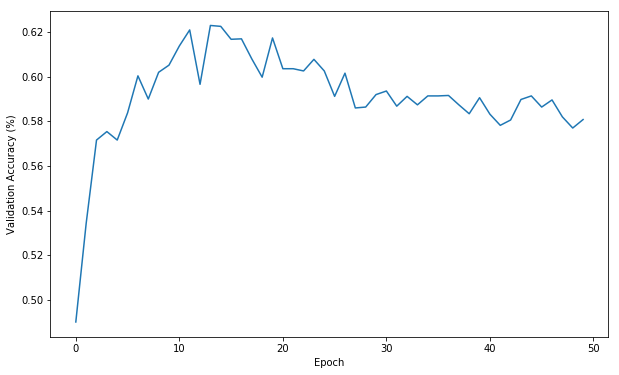

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(acc_val_list)), acc_val_list)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")

We can see that the accuracy reaches 60% around 10 epoches, but drops a little bit probably because of overfitting.